Thanks to: Sebastian Raschka (sraschka@wisc.edu) 

# MLP Pytorch

<a href="https://colab.research.google.com/github/andrescastro-itm/IA_ITM_2025-2/blob/main/Clase14/2_mlp-pytorch_softmax-crossentr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import time

import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch

## Settings and Dataset

In [2]:
##########################
### CONFIGURACIÓN
##########################

RANDOM_SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20#100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [3]:
##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Dimensiones de batch de imágenes:', images.shape)
    print('Dimensiones de batch de etiquetas:', labels.shape)
    break

Dimensiones de batch de imágenes: torch.Size([128, 1, 28, 28])
Dimensiones de batch de etiquetas: torch.Size([128])


## Model

In [4]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        ### 1ra capa oculta
        self.linear_1 = torch.nn.Linear(num_features, num_hidden)

        ### Capa de salida
        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        return logits

    
#################################
### Inicialización del Modelo
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=28*28,
            num_hidden=100, #Optuna
            num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Entrenamiento
#################################

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, targets)
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### PASO HACIA ADELANTE Y PROPAGACIÓN HACIA ATRÁS
        logits = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### Actualización de parámetros del modelo (GD)
        optimizer.step()
        
        ### Registro
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print(f'Época: {epoch+1:03d}/{NUM_EPOCHS:03d} | Batch {batch_idx:03d}/{len(train_loader)} | Costo: {cost.item():.4f}')
        
    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print(f'Época: {epoch+1:03d}/{NUM_EPOCHS:03d} Costo Entrenamiento: {cost:.4f}')
    print(f'Tiempo transcurrido: {((time.time() - start_time)/60):.2f} min')
    
print(f'Tiempo total de entrenamiento: {((time.time() - start_time)/60):.2f} min')

Época: 001/020 | Batch 000/469 | Costo: 2.3647
Época: 001/020 | Batch 050/469 | Costo: 2.1792
Época: 001/020 | Batch 100/469 | Costo: 1.9516
Época: 001/020 | Batch 150/469 | Costo: 1.6483
Época: 001/020 | Batch 200/469 | Costo: 1.3732
Época: 001/020 | Batch 250/469 | Costo: 1.1194
Época: 001/020 | Batch 300/469 | Costo: 0.9884
Época: 001/020 | Batch 350/469 | Costo: 0.8149
Época: 001/020 | Batch 400/469 | Costo: 0.6255
Época: 001/020 | Batch 450/469 | Costo: 0.7252
Época: 001/020 Costo Entrenamiento: 0.6494
Tiempo transcurrido: 0.25 min
Época: 002/020 | Batch 000/469 | Costo: 0.6405
Época: 002/020 | Batch 050/469 | Costo: 0.5762
Época: 002/020 | Batch 100/469 | Costo: 0.5815
Época: 002/020 | Batch 150/469 | Costo: 0.5186
Época: 002/020 | Batch 200/469 | Costo: 0.6054
Época: 002/020 | Batch 250/469 | Costo: 0.4680
Época: 002/020 | Batch 300/469 | Costo: 0.4810
Época: 002/020 | Batch 350/469 | Costo: 0.5423
Época: 002/020 | Batch 400/469 | Costo: 0.4296
Época: 002/020 | Batch 450/469 | C

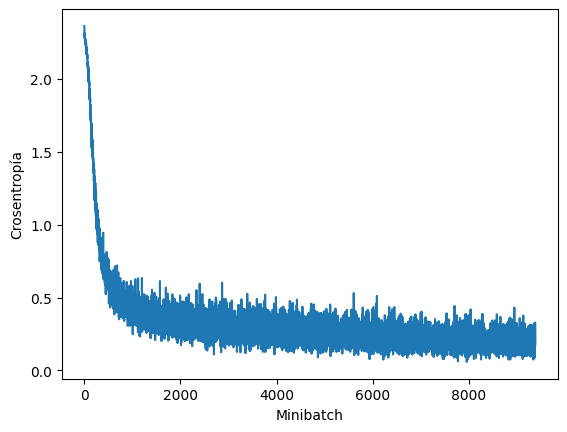

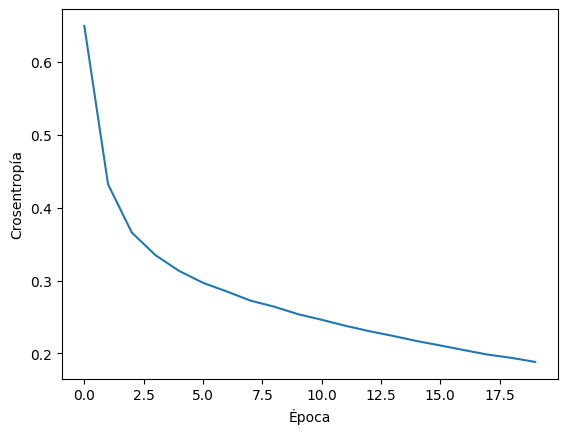

In [5]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Crosentropía')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Crosentropía')
plt.xlabel('Época')
plt.show()

In [6]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.shape[0]
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100
    
print('Exactitud de Entrenamiento: %.2f' % compute_accuracy(model, train_loader))
print('Exactitud de Test: %.2f' % compute_accuracy(model, test_loader))

Exactitud de Entrenamiento: 94.64
Exactitud de Test: 94.53
